<a href="https://colab.research.google.com/github/SumitDS23/Capstone-Project-34/blob/main/MVP_and_HRP_Portfolios_METAL_Sector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP and HRP Portfolio Design for METAL sector Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [2]:
path="https://github.com/SumitDS23/Capstone-Project-34/raw/main/METAL.csv"

In [3]:
# load dataset
dataset = read_csv(path,index_col=0)

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [6]:
# shape
dataset.shape

(991, 10)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head()

,TATASTEEL.NS,ADANIENT.NS,JSWSTEEL.NS,HINDALCO.NS,APLAPOLLO.NS,VEDL.NS,JINDALSTEL.NS,JSL.NS,NMDC.NS,SAIL.NS
2019-07-01,50.695000,154.100006,275.750000,208.899994,155.945007,174.050003,140.000000,35.400002,114.900002,51.099998
2019-07-02,50.880001,154.699997,276.149994,209.350006,161.764999,174.649994,140.800003,33.700001,115.599998,51.250000
2019-07-03,51.029999,155.600006,277.399994,208.699997,164.044998,172.699997,144.199997,32.750000,118.349998,51.700001
2019-07-04,49.529999,156.100006,275.049988,206.899994,165.789993,171.050003,142.100006,33.250000,116.500000,51.900002
2019-07-05,47.834999,147.300003,266.649994,198.899994,161.039993,163.649994,134.100006,32.700001,110.599998,48.349998


<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [8]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(991, 10)

In [9]:
dataset.isnull().sum()/len(dataset)

TATASTEEL.NS     0.000000
ADANIENT.NS      0.000000
JSWSTEEL.NS      0.000000
HINDALCO.NS      0.000000
APLAPOLLO.NS     0.000000
VEDL.NS          0.000000
JINDALSTEL.NS    0.000000
JSL.NS           0.001009
NMDC.NS          0.000000
SAIL.NS          0.000000
dtype: float64

Getting rid of the columns with more than 30% missing values.

In [10]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(991, 10)

Given that there are null values drop the rown contianing the null values.

In [11]:
# Fill the missing values with the last value available in the dataset.
dataset=dataset.fillna(method='ffill')
dataset.head()

,TATASTEEL.NS,ADANIENT.NS,JSWSTEEL.NS,HINDALCO.NS,APLAPOLLO.NS,VEDL.NS,JINDALSTEL.NS,JSL.NS,NMDC.NS,SAIL.NS
2019-07-01,50.695000,154.100006,275.750000,208.899994,155.945007,174.050003,140.000000,35.400002,114.900002,51.099998
2019-07-02,50.880001,154.699997,276.149994,209.350006,161.764999,174.649994,140.800003,33.700001,115.599998,51.250000
2019-07-03,51.029999,155.600006,277.399994,208.699997,164.044998,172.699997,144.199997,32.750000,118.349998,51.700001
2019-07-04,49.529999,156.100006,275.049988,206.899994,165.789993,171.050003,142.100006,33.250000,116.500000,51.900002
2019-07-05,47.834999,147.300003,266.649994,198.899994,161.039993,163.649994,134.100006,32.700001,110.599998,48.349998


<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.35% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [12]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8335)

In [13]:
X_train = X.head(train_len)

In [14]:
X_train

,TATASTEEL.NS,ADANIENT.NS,JSWSTEEL.NS,HINDALCO.NS,APLAPOLLO.NS,VEDL.NS,JINDALSTEL.NS,JSL.NS,NMDC.NS,SAIL.NS
2019-07-01,50.695000,154.100006,275.750000,208.899994,155.945007,174.050003,140.000000,35.400002,114.900002,51.099998
2019-07-02,50.880001,154.699997,276.149994,209.350006,161.764999,174.649994,140.800003,33.700001,115.599998,51.250000
2019-07-03,51.029999,155.600006,277.399994,208.699997,164.044998,172.699997,144.199997,32.750000,118.349998,51.700001
2019-07-04,49.529999,156.100006,275.049988,206.899994,165.789993,171.050003,142.100006,33.250000,116.500000,51.900002
2019-07-05,47.834999,147.300003,266.649994,198.899994,161.039993,163.649994,134.100006,32.700001,110.599998,48.349998
...,...,...,...,...,...,...,...,...,...,...
2022-10-20,100.900002,3357.100098,628.400024,395.200012,1087.000000,282.850006,443.200012,132.199997,132.600006,79.599998
2022-10-21,100.199997,3311.899902,622.049988,393.750000,1077.750000,280.100006,437.950012,132.850006,130.350006,77.849998
2022-10-24,101.199997,3309.800049,629.599976,395.549988,1099.650024,281.750000,438.350006,134.899994,130.949997,78.500000
2022-10-25,101.199997,3300.500000,644.349976,398.399994,1077.349976,280.000000,451.250000,139.149994,130.750000,79.349998


In [15]:
X_test = X.tail(row-train_len)
X_test

,TATASTEEL.NS,ADANIENT.NS,JSWSTEEL.NS,HINDALCO.NS,APLAPOLLO.NS,VEDL.NS,JINDALSTEL.NS,JSL.NS,NMDC.NS,SAIL.NS
2022-10-28,101.599998,3323.300049,670.400024,404.950012,1078.050049,284.850006,453.899994,138.500000,100.949997,78.949997
2022-10-31,101.550003,3347.449951,673.950012,405.649994,1078.949951,280.799988,459.850006,141.550003,99.750000,78.699997
2022-11-01,101.199997,3575.699951,686.349976,414.399994,1084.349976,286.899994,465.000000,147.949997,104.599998,80.000000
2022-11-02,101.250000,3580.699951,684.200012,421.299988,1088.800049,297.250000,470.049988,147.000000,109.250000,80.449997
2022-11-03,102.000000,3590.399902,680.200012,410.350006,1091.849976,302.899994,468.850006,148.699997,110.599998,81.300003
...,...,...,...,...,...,...,...,...,...,...
2023-06-22,111.099998,2397.250000,752.349976,420.049988,1391.400024,280.649994,584.099976,327.700012,105.750000,85.150002
2023-06-23,109.599998,2233.550049,746.500000,408.500000,1337.199951,276.200012,568.849976,324.750000,104.699997,84.400002
2023-06-26,109.849998,2295.600098,748.799988,414.700012,1309.949951,279.799988,567.700012,327.950012,104.800003,84.449997
2023-06-27,110.750000,2284.449951,762.500000,417.750000,1337.800049,279.549988,581.950012,330.200012,104.500000,85.000000


In [16]:
#Calculate percentage return
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

In [17]:
returns

,TATASTEEL.NS,ADANIENT.NS,JSWSTEEL.NS,HINDALCO.NS,APLAPOLLO.NS,VEDL.NS,JINDALSTEL.NS,JSL.NS,NMDC.NS,SAIL.NS
2019-07-02,0.003649,0.003894,0.001451,0.002154,0.037321,0.003447,0.005714,-0.048023,0.006092,0.002935
2019-07-03,0.002948,0.005818,0.004527,-0.003105,0.014095,-0.011165,0.024148,-0.028190,0.023789,0.008781
2019-07-04,-0.029394,0.003213,-0.008472,-0.008625,0.010637,-0.009554,-0.014563,0.015267,-0.015632,0.003868
2019-07-05,-0.034222,-0.056374,-0.030540,-0.038666,-0.028651,-0.043262,-0.056298,-0.016541,-0.050644,-0.068401
2019-07-08,-0.021532,-0.057027,-0.016501,-0.006536,0.002204,-0.010388,0.009321,-0.030581,-0.033454,-0.042399
...,...,...,...,...,...,...,...,...,...,...
2022-10-20,0.008496,0.024365,0.003994,0.012555,-0.025636,0.020198,0.007845,-0.021466,0.009901,0.015306
2022-10-21,-0.006938,-0.013464,-0.010105,-0.003669,-0.008510,-0.009722,-0.011846,0.004917,-0.016968,-0.021985
2022-10-24,0.009980,-0.000634,0.012137,0.004571,0.020320,0.005891,0.000913,0.015431,0.004603,0.008349
2022-10-25,0.000000,-0.002810,0.023428,0.007205,-0.020279,-0.006211,0.029429,0.031505,-0.001527,0.010828


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [18]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [19]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([0.        , 2.        , 0.46650931, 2.        ])

In [20]:
link.shape

(9, 4)

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

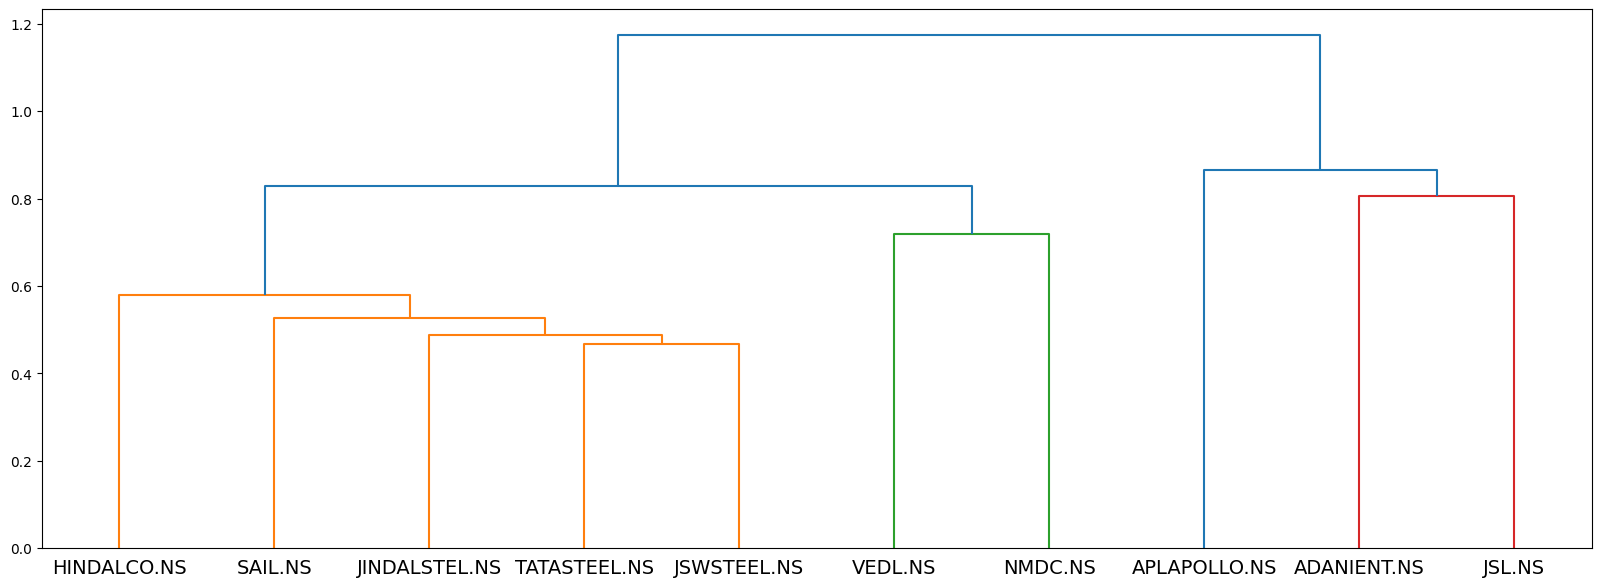

In [21]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [22]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [23]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [24]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)


    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [25]:
def get_all_portfolios(returns):

    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [26]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                    MVP       HRP
TATASTEEL.NS   0.051471  0.065430
ADANIENT.NS    0.193587  0.154114
JSWSTEEL.NS    0.167824  0.071122
HINDALCO.NS    0.037576  0.106865
APLAPOLLO.NS   0.299779  0.168582
VEDL.NS        0.043029  0.082607
JINDALSTEL.NS  0.000819  0.069331
JSL.NS         0.041113  0.101133
NMDC.NS        0.162481  0.098381
SAIL.NS        0.002320  0.082437


Text(0.5, 1.0, 'HRP')

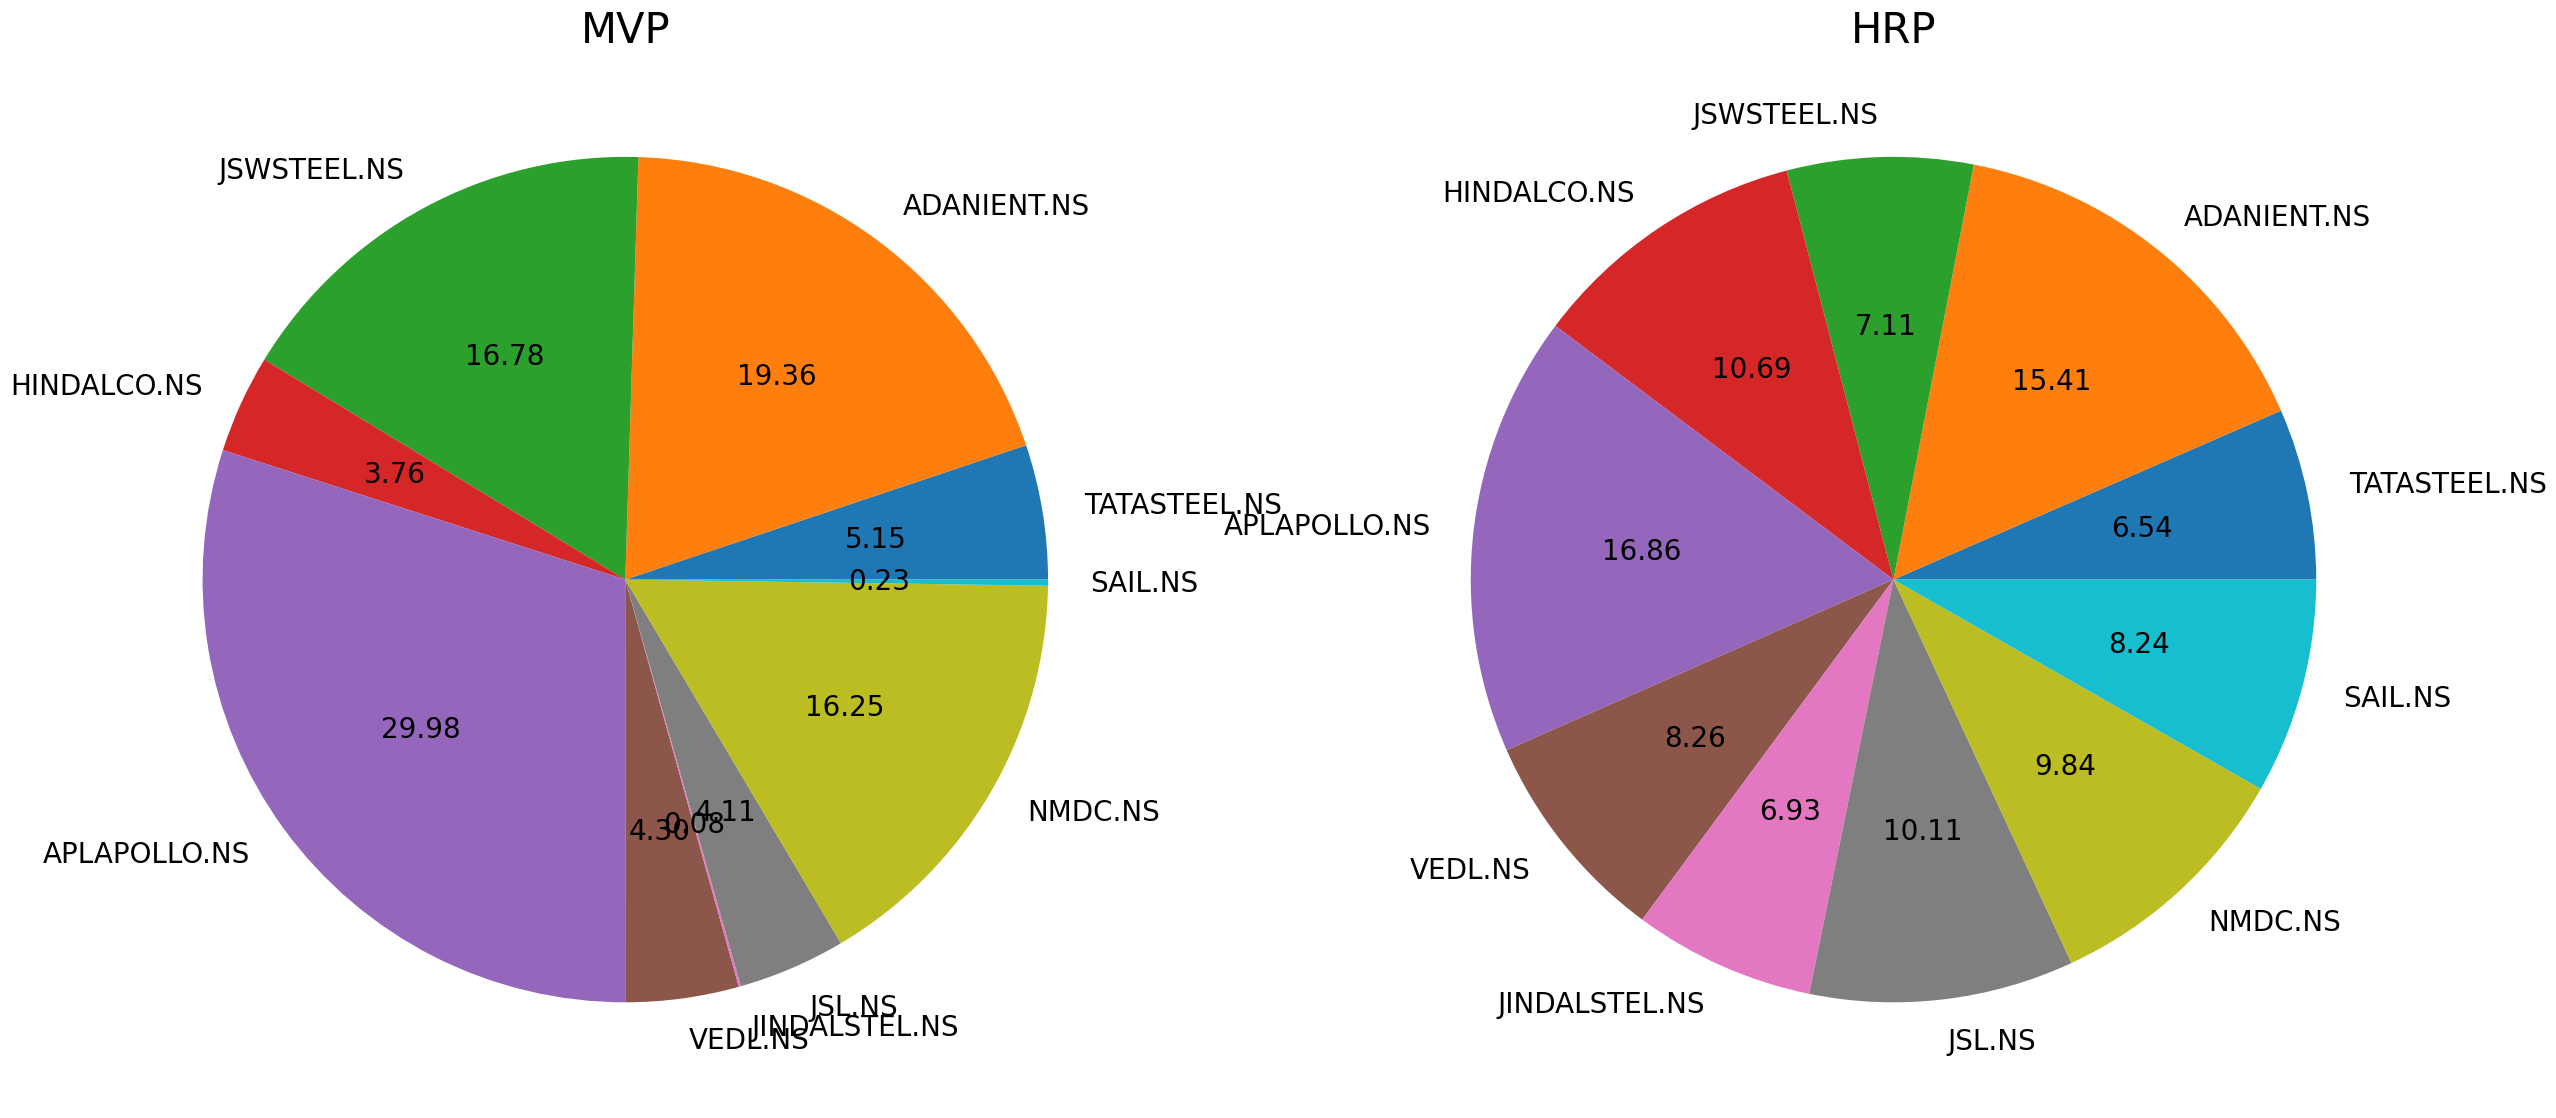

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [28]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

TATASTEEL.NS     0.051471
ADANIENT.NS      0.193587
JSWSTEEL.NS      0.167824
HINDALCO.NS      0.037576
APLAPOLLO.NS     0.299779
VEDL.NS          0.043029
JINDALSTEL.NS    0.000819
JSL.NS           0.041113
NMDC.NS          0.162481
SAIL.NS          0.002320
Name: MVP, dtype: float64

In [29]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

TATASTEEL.NS     0.065430
ADANIENT.NS      0.154114
JSWSTEEL.NS      0.071122
HINDALCO.NS      0.106865
APLAPOLLO.NS     0.168582
VEDL.NS          0.082607
JINDALSTEL.NS    0.069331
JSL.NS           0.101133
NMDC.NS          0.098381
SAIL.NS          0.082437
Name: HRP, dtype: float64

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios

### 5.1 Cumulative Returns - Training and Test Data

In [30]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<Axes: ylabel='Return'>

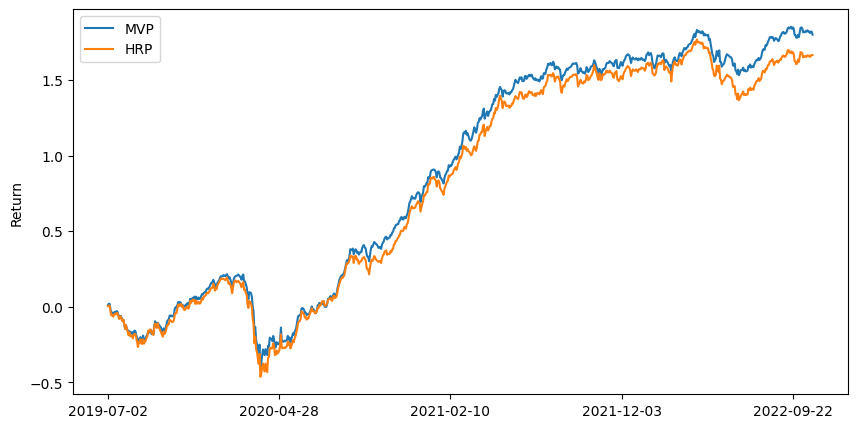

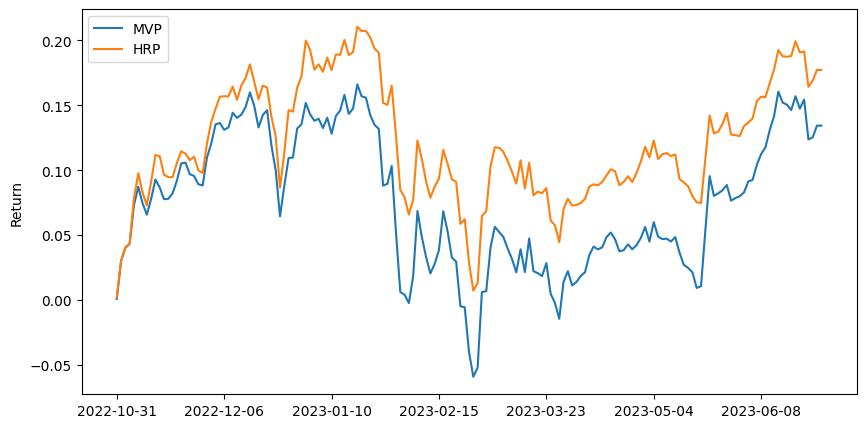

In [31]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [32]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.550291
HRP    0.508932
dtype: float64

In [33]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.205297
HRP    0.270802
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [34]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
MVP,0.327233,1.681651
HRP,0.348185,1.461669


In [35]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.254846,0.805572
HRP,0.241425,1.121680
